# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link:

https://colab.research.google.com/drive/1Ay8MgIxTno4Jg7Lu2bnCD4FA0E1f75vC?usp=sharing


As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html



In [1]:
!pip install torchtext==0.6

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

In [3]:
!unzip sms+spam+collection.zip

Archive:  sms+spam+collection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

**ANSWER:** label value for a spam message is "spam" and for a non-spam message is "ham"

In [4]:
for line in open('SMSSpamCollection'):
  if line[:3] == 'ham':
    print('Non Spam Message: ', line[4:])
    break

for line in open('SMSSpamCollection'):
  if line[:4] == 'spam':
    print('Spam Message: ', line[5:])
    break

Non Spam Message:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Spam Message:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's



### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [5]:
spam_count = 0
non_spam = 0
for line in open('SMSSpamCollection'):
  if line[:4] == 'spam':
    spam_count += 1
  else:
    non_spam += 1

print(f'No of spam messages is {spam_count}')
print(f'No of non-spam messages is {non_spam}')

No of spam messages is 747
No of non-spam messages is 4827


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

**ANSWER:**

Advantages of character level RNN over word level RNN:
1. Character level RNN models have smaller input size as the total inputs is just limited to the total number of different characters (26 letters in English) whereas Model level RNNs have much larger input sizes as the total inputs is equal to the total number of words (thousands or hundreds of English words)
2. Character level RNN models have finer granularity and more robust to spelling and typographical errors as they capture sub-word structures and dependencies at the character level

Disadvantages of character level RNN over word level RNN:
1. Character level RNNs have longer training times due to character level processing compared to word level processing when the sequences are long.
2. It has increased model complexity as it requires more layers to capture meaningful patterns. It is also challenging capturing higher order semantic relationships between words using character level RNNs compared to word level RNNs.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file.

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file.
In our case, the dataset has two fields:

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.


In [6]:
#Converting the SMSSpamCollection into a CSV File
import pandas as pd
labels = []
texts = []
for line in open('SMSSpamCollection'):
  if line[:4] == 'spam':
    labels.append(1)
    texts.append(line[5:])
  else:
    labels.append(0)
    texts.append(line[4:])

pd.DataFrame([(labels[i], texts[i]) for i in range(len(labels))], columns=['label', 'sms']).to_csv('SMSSpamCollection.csv')

In [7]:
import torchtext
import spacy
from torchtext import data

#Creating the text and label fields
text_field = data.Field(sequential = True, tokenize= lambda x:list(x), use_vocab = True, lower=True, include_lengths = True)
label_field = data.Field(sequential = False, use_vocab = False, pad_token = None, unk_token = None)

fields = [('id', None),('label', label_field), ('sms', text_field)]

In [8]:
#Creating the Tabular Dataset
dataset = data.TabularDataset('/content/SMSSpamCollection.csv', 'CSV', fields, skip_header=True)

In [9]:
import random
random.seed(42)

In [171]:
train, valid, test = dataset.split(split_ratio=[0.6, 0.2, 0.2]) #Splitting into train, test and validation

### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

**ANSWER:**
Having a balanced dataset ensures that our model is not biased towards classes that have more samples in the train dataset.

Note: if you are not sure, try removing the below code and train your model.

In [173]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if int(item.label) == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

**ANSWER:**
`text_field.vocab.stoi` contains the unique integers each word is mapped to whereas `text_field.vocab.itos` contains the reverse mapping (words arranged according to their mapped integers as their index)

In [183]:
text_field.build_vocab(train)
text_field.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x79e899703130>>,
            {'<unk>': 0,
             '<pad>': 1,
             ' ': 2,
             'e': 3,
             'o': 4,
             't': 5,
             'a': 6,
             'n': 7,
             'i': 8,
             'r': 9,
             's': 10,
             'l': 11,
             'u': 12,
             'c': 13,
             'h': 14,
             'd': 15,
             'm': 16,
             '0': 17,
             'y': 18,
             'w': 19,
             '.': 20,
             'p': 21,
             'g': 22,
             'f': 23,
             'b': 24,
             '1': 25,
             'k': 26,
             '2': 27,
             '8': 28,
             'v': 29,
             'x': 30,
             '5': 31,
             '4': 32,
             '7': 33,
             '6': 34,
             '3': 35,
             '!': 36,
             ',': 37,
             '9': 38,
             '/': 39,
             "'":

In [184]:
text_field.vocab.itos

['<unk>',
 '<pad>',
 ' ',
 'e',
 'o',
 't',
 'a',
 'n',
 'i',
 'r',
 's',
 'l',
 'u',
 'c',
 'h',
 'd',
 'm',
 '0',
 'y',
 'w',
 '.',
 'p',
 'g',
 'f',
 'b',
 '1',
 'k',
 '2',
 '8',
 'v',
 'x',
 '5',
 '4',
 '7',
 '6',
 '3',
 '!',
 ',',
 '9',
 '/',
 "'",
 '?',
 '£',
 '-',
 'j',
 '&',
 ':',
 'z',
 ')',
 '+',
 ';',
 'q',
 '*',
 '"',
 '(',
 '#',
 '>',
 'ü',
 '=',
 '@',
 '<',
 '|',
 '\x92',
 '‘',
 '$',
 '_',
 '¡',
 '[',
 ']',
 '’',
 '\x93',
 '…',
 '%',
 '\x94',
 'é',
 '–',
 '\\',
 '~',
 '\x96',
 '^',
 '\x91',
 '»',
 '—',
 '┾',
 '〨',
 '鈥']

In [185]:
len(text_field.vocab.stoi)

86

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

**ANSWER:**
`<unk>` refers to unknown or words that are not present in the vocabulary whereas `<pad>` is added to ensure that all input sequences are of same length.

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [175]:
train_iter = torchtext.data.BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.sms), sort_within_batch=True, repeat=False)

In [176]:
#Taking a look at first 10 batches
k = 1
for batch in train_iter:
  sms, lengths = batch.sms
  labels = batch.label
  paddings = torch.sum(sms==1).item()
  print(f'Batch {k}    Max Length {torch.max(lengths).item()}   Paddings {paddings}')
  k+=1
  if k>10:
    break

Batch 1    Max Length 148   Paddings 8
Batch 2    Max Length 45   Paddings 22
Batch 3    Max Length 138   Paddings 21
Batch 4    Max Length 87   Paddings 37
Batch 5    Max Length 74   Paddings 13
Batch 6    Max Length 149   Paddings 0
Batch 7    Max Length 116   Paddings 45
Batch 8    Max Length 139   Paddings 8
Batch 9    Max Length 14   Paddings 174
Batch 10    Max Length 156   Paddings 0


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing.
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a
fully-connected
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0],
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [79]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [177]:
class SpamDetector(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(SpamDetector, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, 1)

  def forward(self, x):
    encoder = torch.eye(self.input_size)
    x = encoder[x]
    h0 = torch.zeros(1, x.size(0), self.hidden_size)
    out, _ = self.rnn(x, h0)
    return self.fc(torch.max(out, dim=1)[0])

In [178]:
model = SpamDetector(input_size = len(text_field.vocab.itos), hidden_size = len(text_field.vocab.itos))

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [179]:
def get_accuracy(model, data, batch_size=32):
    """ Compute the accuracy of the `model` across a dataset `data`

    Example usage:

    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    data_loader = torchtext.data.BucketIterator(data,
                                                batch_size=batch_size,
                                                sort_key=lambda x: len(x.sms), # to minimize padding
                                                sort_within_batch=True,        # sort within each batch
                                                repeat=False)                  # repeat the iterator for many epochs
    corr = 0
    total = 0
    for batch in data_loader:
      sms, lengths = batch.sms
      sms = torch.transpose(sms, 0, 1)
      labels = batch.label
      output = model(sms)
      preds = torch.round(F.sigmoid(output)).squeeze(dim=1)
      corr += torch.sum(preds == labels).item()
      total += len(labels)

    return corr/total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model.
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest.

In [180]:
import matplotlib.pyplot as plt
#Train Function
def train_model(model, train_iter, val, batch_size=32, lr=0.001, num_epochs=15):

  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.BCEWithLogitsLoss()
  train_loss = []
  train_acc = []
  val_acc = []
  iterations = []
  iter = 0
  for i in range(num_epochs):
    loss = 0
    acc = 0
    corr = 0
    total = 0
    for batch in train_iter:
      sms, lengths = batch.sms
      labels = batch.label
      sms = torch.transpose(sms, 0, 1)
      output = model(sms)
      preds = torch.round(F.sigmoid(output)).squeeze(dim=1)

      optimizer.zero_grad()
      loss = criterion(F.sigmoid(output).squeeze(dim=1), labels.float())
      loss.backward()
      optimizer.step()

      loss += loss
      corr += torch.sum(preds == labels).item()
      total += len(labels)
      iter += len(labels)
    acc = corr/total
    loss = loss
    valacc = get_accuracy(model, val, batch_size)
    train_loss.append(loss.detach().item())
    train_acc.append(acc)
    val_acc.append(valacc)
    iterations.append(iter)

    print(f'Epoch {i+1} Training Loss {loss} Training Accuracy {acc} Validation Accuracy {valacc}')

  plt.figure(figsize=(5, 5))
  plt.plot(iterations, train_loss, label='Training Loss')
  plt.title('Training Loss')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.legend()

  plt.figure(figsize=(5,5))
  plt.plot(iterations, train_acc, label='Training Acc')
  plt.plot(iterations, val_acc, label='Validation Acc')
  plt.title('Accuracy')
  plt.xlabel('Iterations')
  plt.ylabel('Accuracy')
  plt.legend()

Epoch 1 Training Loss 1.4978313446044922 Training Accuracy 0.7591929710380736 Validation Accuracy 0.967713004484305
Epoch 2 Training Loss 0.8440186977386475 Training Accuracy 0.9371949235274976 Validation Accuracy 0.9695067264573991
Epoch 3 Training Loss 0.9413655996322632 Training Accuracy 0.9438659290595509 Validation Accuracy 0.9551569506726457
Epoch 4 Training Loss 1.0793708562850952 Training Accuracy 0.9524894240156199 Validation Accuracy 0.9713004484304932
Epoch 5 Training Loss 0.6773699522018433 Training Accuracy 0.9539537910836317 Validation Accuracy 0.9650224215246637
Epoch 6 Training Loss 1.3885252475738525 Training Accuracy 0.9583468922876668 Validation Accuracy 0.9695067264573991
Epoch 7 Training Loss 1.3961546421051025 Training Accuracy 0.9598112593556785 Validation Accuracy 0.9721973094170404
Epoch 8 Training Loss 1.3876805305480957 Training Accuracy 0.9546046208916369 Validation Accuracy 0.9695067264573991
Epoch 9 Training Loss 0.9356930255889893 Training Accuracy 0.9604

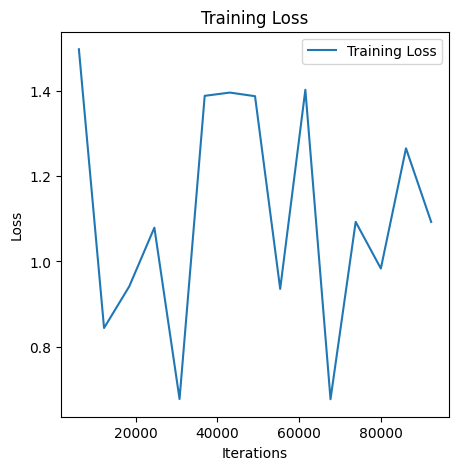

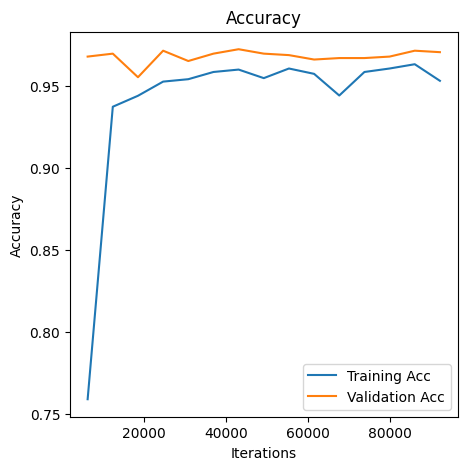

In [181]:
train_model(model, train_iter, valid)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch.
Choose at least 2 hyperparameters that are unrelated to the optimizer.

Hyperparameters tuned are:
1. Batch Size
2. Learning Rate
3. Epochs
4. Model Architecture (RNN and Linear Layers)

The first hyperparameters are a general set consisting of a batch size of 128, learning rate of 0.01 and 20 epochs. Increased the batch size and learning rate to make convergence faster. The model architecture remains same (One RNN and one linear layer). Training Loss is at 1.184 and Validation accuracy is at 98%.

In [190]:
model_2 = SpamDetector(input_size = len(text_field.vocab.itos), hidden_size = len(text_field.vocab.itos))

In [191]:
train_iter_2 = torchtext.data.BucketIterator(train, batch_size=128, sort_key=lambda x: len(x.sms), sort_within_batch=True, repeat=False)

In [192]:
import matplotlib.pyplot as plt
#Train Function
def train_model(model, train_iter, val, batch_size=32, lr=0.001, num_epochs=15):

  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.BCEWithLogitsLoss()
  train_loss = []
  train_acc = []
  val_acc = []
  iterations = []
  iter = 0
  for i in range(num_epochs):
    loss = 0
    acc = 0
    corr = 0
    total = 0
    for batch in train_iter:
      sms, lengths = batch.sms
      labels = batch.label
      sms = torch.transpose(sms, 0, 1)
      output = model(sms)
      preds = torch.round(F.sigmoid(output)).squeeze(dim=1)

      optimizer.zero_grad()
      loss = criterion(F.sigmoid(output).squeeze(dim=1), labels.float())
      loss.backward()
      optimizer.step()

      loss += loss
      corr += torch.sum(preds == labels).item()
      total += len(labels)
      iter += len(labels)
    acc = corr/total
    loss = loss
    valacc = get_accuracy(model, val, batch_size)
    train_loss.append(loss.detach().item())
    train_acc.append(acc)
    val_acc.append(valacc)
    iterations.append(iter)

    print(f'Epoch {i+1} Training Loss {loss} Training Accuracy {acc} Validation Accuracy {valacc}')

  plt.figure(figsize=(5, 5))
  plt.plot(iterations, train_loss, label='Training Loss')
  plt.title('Training Loss')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.legend()

  plt.figure(figsize=(5,5))
  plt.plot(iterations, train_acc, label='Training Acc')
  plt.plot(iterations, val_acc, label='Validation Acc')
  plt.title('Accuracy')
  plt.xlabel('Iterations')
  plt.ylabel('Accuracy')
  plt.legend()

Epoch 1 Training Loss 0.8205929398536682 Training Accuracy 0.8247640741945981 Validation Accuracy 0.9659192825112107
Epoch 2 Training Loss 1.311896800994873 Training Accuracy 0.8856166612430849 Validation Accuracy 0.9739910313901345
Epoch 3 Training Loss 0.7516429424285889 Training Accuracy 0.9183208590953466 Validation Accuracy 0.9713004484304932
Epoch 4 Training Loss 0.9033793807029724 Training Accuracy 0.9410999023755288 Validation Accuracy 0.9739910313901345
Epoch 5 Training Loss 0.6828107833862305 Training Accuracy 0.9020501138952164 Validation Accuracy 0.9704035874439462
Epoch 6 Training Loss 1.3496558666229248 Training Accuracy 0.9386592905955092 Validation Accuracy 0.9695067264573991
Epoch 7 Training Loss 0.6694181561470032 Training Accuracy 0.9448421737715588 Validation Accuracy 0.9713004484304932
Epoch 8 Training Loss 1.206594705581665 Training Accuracy 0.9466319557435731 Validation Accuracy 0.9721973094170404
Epoch 9 Training Loss 1.3574366569519043 Training Accuracy 0.94777

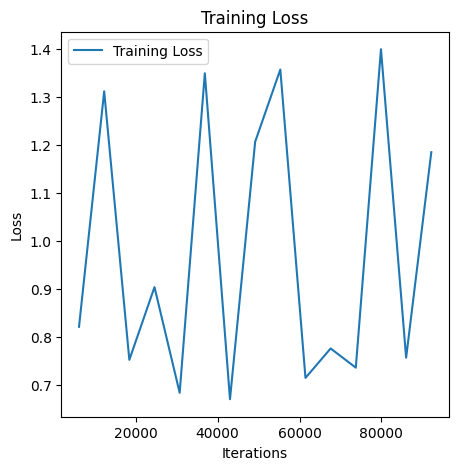

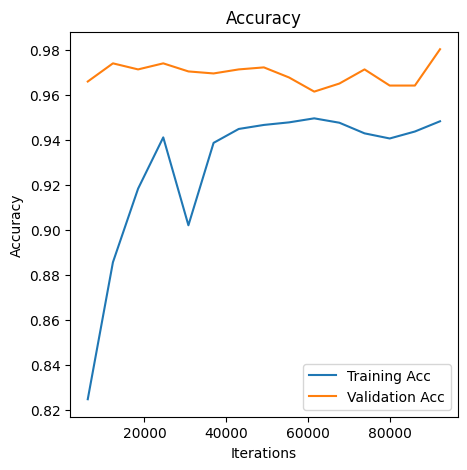

In [193]:
train_model(model_2, train_iter_2, valid, batch_size=128, lr=0.01, num_epochs=15)

Based on the previous exercise, we see that loss fluctuates a lot indicating a high learning rate. So we decrease the learning rate to 0.0001 and also reduce the number of epochs to 10 to prevent overfitting. Training Loss is at 1.29 and Validation accuracy at 86%. Model however doesn't learn and doesn't perform well on training due to overfitting and low learning rate.


In [194]:
model_3 = SpamDetector(input_size = len(text_field.vocab.itos), hidden_size = len(text_field.vocab.itos))

Epoch 1 Training Loss 1.062443494796753 Training Accuracy 0.5318906605922551 Validation Accuracy 0.13183856502242153
Epoch 2 Training Loss 1.5935053825378418 Training Accuracy 0.5815164334526521 Validation Accuracy 0.9076233183856502
Epoch 3 Training Loss 1.0318622589111328 Training Accuracy 0.6970387243735763 Validation Accuracy 0.8681614349775785
Epoch 4 Training Loss 1.0317548513412476 Training Accuracy 0.46810933940774485 Validation Accuracy 0.8681614349775785
Epoch 5 Training Loss 1.868675947189331 Training Accuracy 0.46810933940774485 Validation Accuracy 0.8681614349775785
Epoch 6 Training Loss 1.7875733375549316 Training Accuracy 0.46810933940774485 Validation Accuracy 0.8681614349775785
Epoch 7 Training Loss 1.1319410800933838 Training Accuracy 0.46810933940774485 Validation Accuracy 0.8681614349775785
Epoch 8 Training Loss 1.7916604280471802 Training Accuracy 0.46810933940774485 Validation Accuracy 0.8681614349775785
Epoch 9 Training Loss 1.3059128522872925 Training Accuracy 0

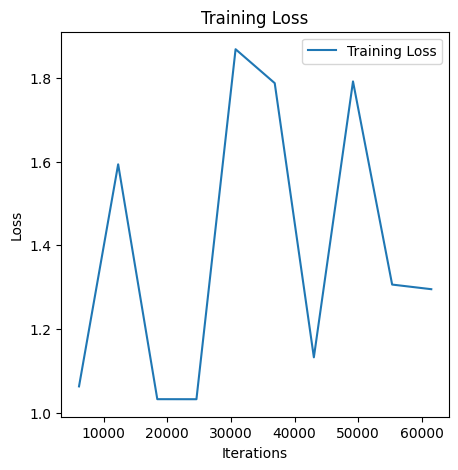

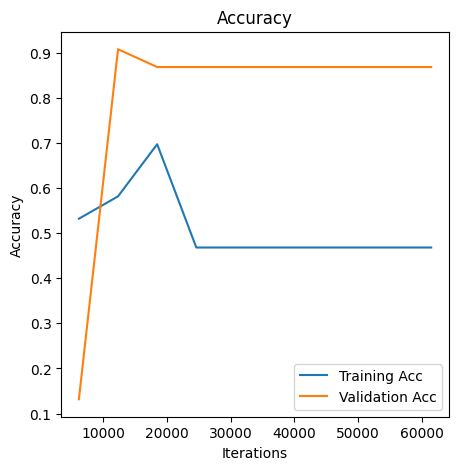

In [195]:
train_model(model_3, train_iter_2, valid, batch_size=128, lr=0.0001, num_epochs=10)

We also see the effect of having a deeper RNN and more linear layers by increasing the RNN Layers to 4. Also keep the batch size low at 32 to introduce noise and a small learning rate of 0.001 to ensure better training (only 10 epochs to prevent overfitting). The model overfitted towards the end causing drastic decrease in accuracy and sharp increase in loss.


In [196]:
class SpamDetector3(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(SpamDetector3, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, num_layers = 4, batch_first=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size, 10), nn.ReLU(), nn.Linear(10,1))

  def forward(self, x):
    encoder = torch.eye(self.input_size)
    x = encoder[x]
    h0 = torch.zeros(4, x.size(0), self.hidden_size)
    out, _ = self.rnn(x, h0)
    return self.fc(torch.max(out, dim=1)[0])

In [197]:
train_iter_4 = torchtext.data.BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.sms), sort_within_batch=True, repeat=False)

In [200]:
model_4 = SpamDetector3(input_size = len(text_field.vocab.itos), hidden_size = len(text_field.vocab.itos))

Epoch 1 Training Loss 1.0582852363586426 Training Accuracy 0.8154897494305239 Validation Accuracy 0.9748878923766816
Epoch 2 Training Loss 1.2928497791290283 Training Accuracy 0.9402863651155223 Validation Accuracy 0.9713004484304932
Epoch 3 Training Loss 1.3394073247909546 Training Accuracy 0.9202733485193622 Validation Accuracy 0.9721973094170404
Epoch 4 Training Loss 1.0305531024932861 Training Accuracy 0.935242434103482 Validation Accuracy 0.9704035874439462
Epoch 5 Training Loss 1.3777003288269043 Training Accuracy 0.9485844451675887 Validation Accuracy 0.9704035874439462
Epoch 6 Training Loss 0.6740984320640564 Training Accuracy 0.9461438333875691 Validation Accuracy 0.9659192825112107
Epoch 7 Training Loss 0.7690311670303345 Training Accuracy 0.9437032216075496 Validation Accuracy 0.9614349775784753
Epoch 8 Training Loss 1.3863401412963867 Training Accuracy 0.9342661893914741 Validation Accuracy 0.9739910313901345
Epoch 9 Training Loss 0.7201524972915649 Training Accuracy 0.9357

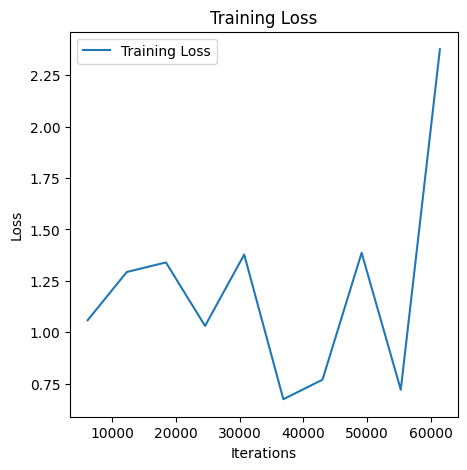

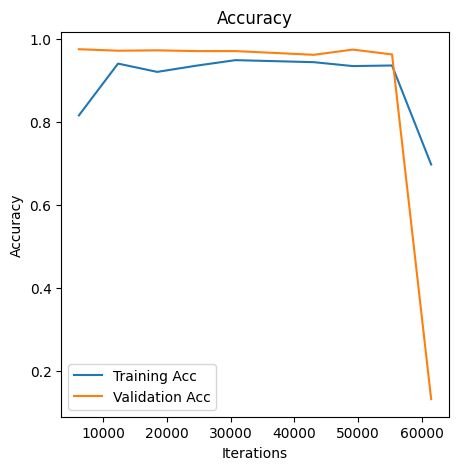

In [201]:
train_model(model_4, train_iter_4, valid, batch_size=32, lr=0.001, num_epochs=10)

Lastly, since 10 epochs overfitted the data towards the end, I used 7 epochs this time to train the same model, keeping all parameters same. Model achieves 82% validation accuracy and 1.12 loss.

In [209]:
class SpamDetector4(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(SpamDetector4, self).__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.rnn = nn.RNN(input_size, hidden_size, num_layers = 4, batch_first=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size, 10), nn.ReLU(), nn.Linear(10,1))

  def forward(self, x):
    encoder = torch.eye(self.input_size)
    x = encoder[x]
    h0 = torch.zeros(4, x.size(0), self.hidden_size)
    out, _ = self.rnn(x, h0)
    return self.fc(torch.max(out, dim=1)[0])

In [212]:
model_5 = SpamDetector4(input_size = len(text_field.vocab.itos), hidden_size = len(text_field.vocab.itos))

Epoch 1 Training Loss 1.2930294275283813 Training Accuracy 0.510250569476082 Validation Accuracy 0.8762331838565023
Epoch 2 Training Loss 1.5016322135925293 Training Accuracy 0.6301659616010413 Validation Accuracy 0.8394618834080717
Epoch 3 Training Loss 1.1267796754837036 Training Accuracy 0.6282134721770257 Validation Accuracy 0.8430493273542601
Epoch 4 Training Loss 1.408722162246704 Training Accuracy 0.6324438659290595 Validation Accuracy 0.8430493273542601
Epoch 5 Training Loss 1.361885666847229 Training Accuracy 0.6324438659290595 Validation Accuracy 0.8430493273542601
Epoch 6 Training Loss 1.2589282989501953 Training Accuracy 0.6383013342011065 Validation Accuracy 0.8242152466367713
Epoch 7 Training Loss 1.1262073516845703 Training Accuracy 0.6461112918971689 Validation Accuracy 0.8242152466367713


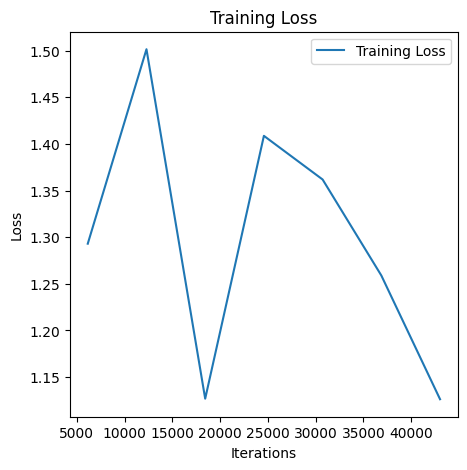

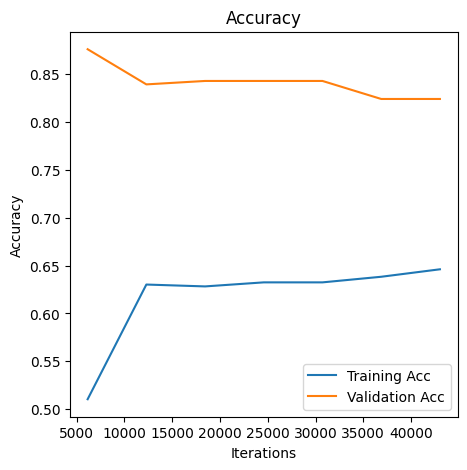

In [213]:
train_model(model_5, train_iter_4, valid, batch_size=32, lr=0.001, num_epochs=7)

`model_2` has the best loss and accuracy (model performance).

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

**ANSWER:**
Model Version 2 has false positive rate of 1% and has a false negative rate of 11%.

In [214]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.data.Dataset([e for e in valid.examples if int(e.label) == 1], valid.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.data.Dataset(
    [e for e in valid.examples if int(e.label) == 0], valid.fields)

In [217]:
get_accuracy(model_2, valid_spam, 128)

0.891156462585034

In [218]:
get_accuracy(model_2, valid_nospam, 128)

0.993801652892562

### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

False positives mean that the user's phone will have important messages marked as spam and will lose valuable messages whereas false negatives mean that certain spam messages will not be marked as spam and the user will have some spam messages in their messages inbox as well.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

**ANSWER:**
Final Test Accuracy = 98%

In [219]:
get_accuracy(model_2, test, 128)

0.9802690582959641

### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

**ANSWER:**
False positive: 1%
False Negative: 11%

In [224]:
# Create a Dataset of only spam validation examples
test_spam = torchtext.data.Dataset([e for e in test.examples if int(e.label) == 1], test.fields)
# Create a Dataset of only non-spam validation examples
test_nospam = torchtext.data.Dataset(
    [e for e in test.examples if int(e.label) == 0], test.fields)

In [225]:
get_accuracy(model_2, test_spam, 128)

0.8947368421052632

In [226]:
get_accuracy(model_2, test_nospam, 128)

0.9918533604887984

### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

**ANSWER:**
Probability is 1.84e-5 or almost 0. Predicted label is 0(non spam).

In [227]:
msg = "machine learning is sooo cool!"

In [228]:
msg_tensor = torch.tensor(np.array([text_field.vocab.stoi[i] for i in list(msg)])) #Convert characters to integers

In [238]:
msg_tensor = msg_tensor.reshape(([1, 30]))

In [239]:
F.sigmoid(model_2(msg_tensor)).item()

1.8407889001537114e-05

### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

Detection Spam is not as difficult as it seems as Spam messages often have similar patterns or use of common words or themes. So, A baseline model that could be utilised should contain heuristic functions that look for keywords that are common in spam messages. These could be words such as "congratulations", "lottery", "free", "prize" and others that are common in spam messages. If the message contains a certain number of these words, then it could be marked as spam.